# 프로젝트: 뉴스기사 요약해보기
---
* Step 1. 데이터 수집하기
* Step 2. 데이터 전처리하기 (추상적 요약)
* Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
* Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
* Step 5. Summa을 이용해서 추출적 요약해보기

In [73]:
# 주요 라이브러리 불러오기 및 버전 확인
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd
import nltk # nltk 라이브러리 불러오기
nltk.download('stopwords') # nltk 패키지에서 불용어 사전을 다운로드
import numpy as np # numpy 라이브러리 불러오기
import os # os 모듈 불러오기
import re  # re 모듈 불러오기
import matplotlib.pyplot as plt # pyplot 모듈 불러오기
from nltk.corpus import stopwords # stopwords 불용어 사전 불러오기
from bs4 import BeautifulSoup # BeautifulSoup 모듈 불러오기
from tensorflow.keras.preprocessing.text import Tokenizer # Tokenizer 모듈 불러오기
from tensorflow.keras.preprocessing.sequence import pad_sequences # pad_sequences 함수 불러오기
import warnings # warnings 모듈을 사용하여 경고를 무시
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print(nltk.__version__)
print(tensorflow.__version__)
print(pandas.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 1. 데이터 수집하기

데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용

https://github.com/sunnysai12345/News_Summary

In [74]:
# 데이터 다운로드
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv") # URL에서 파일을 다운로드하고 news_summary_more.csv라는 파일명으로 로컬에 저장 
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1') # CSV 파일의 내용을 데이터프레임 형태로 읽어온다.
                                                                   # 'iso-8859-1'은 텍스트 데이터를 인코딩하는 방식 중 하나이다. 영어와 서유럽 언어를 포함한 다양한 언어의 문자를 나타내는 데 사용된다.
                                                                   # CSV 파일을 읽을 때 인코딩을 지정하는 것은 파일의 문자를 컴퓨터가 이해할 수 있는 형태로 변환하는 과정이다.

In [75]:
# 랜덤으로 샘플 10개 확인
data.sample(10)

,headlines,text
66390,Thounaojam becomes India's first-ever FIFA Wor...,Sixteen-year-old Jeakson Thounaojam became the...
20905,"People want change, Rahul working hard: Brothe...",Congress President Rahul Gandhi's brother-in-l...
86596,Denmark scraps 334-year-old blasphemy law,Danish lawmakers have repealed a 334-year-old ...
44734,Users report Amazon's speaker makes random lau...,Users of Amazon's smart speaker Echo have repo...
40218,Menu of first Indian restaurant in UK auctione...,The handwritten menu of the first Indian resta...
9241,FIR against ex-DUSU Prez Ankiv Baisoya over fa...,The Delhi Police on Tuesday filed an FIR again...
48059,Official portraits of Barack and Michelle Obam...,The Smithsonian's National Portrait Gallery on...
63931,Ban namaz at Taj Mahal or allow Shiva prayers ...,"The history wing of RSS, Akhil Bharatiya Itiha..."
62128,Hoax bomb threat letter found on Delhi-Kolkata...,A Delhi-Kolkata GoAir flight made an emergency...
72014,"Guard tries to park doctor's car, rams six pat...",A security guard who volunteered to park a doc...


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어 있다.

* 추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있다.
* 추출적 요약을 하는 경우에는 오직 text열만 사용한다.

In [76]:
# 전체 데이터 수 - 데이터프레임의 행의 개수를 세어준다.
len(data)

98401

# Step 2. 데이터 전처리하기 (추상적 요약)

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보자. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보자.

In [77]:
# 데이터의 중복 샘플 유무 확인
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique()) # 해당 열의 중복되지 않은 값의 개수를 반환
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique()) # 해당 열의 중복되지 않은 값의 개수를 반환

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [78]:
# text 열을 기준으로 중복 샘플 제거
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True) # True로 설정할 경우, 새로운 데이터프레임을 반환하지 않고, 해당 데이터프레임의 내용을 직접 변경
                                                      # False로 설정할 경우, 기본적으로 새로운 데이터프레임을 반환하고 원본은 변경하지 않음
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


전체 샘플 수가 98360개로 줄어들었다. 그러나 만약 데이터 Null 값을 가지는 샘플이 있었다면, drop_duplicates()가 중복된 Null들을 지워주기는 했겠지만, 여전히 Null 값 한 개가 어딘가 남아있을 수 있다. 데이터에 Null 값이 남아있는지 보자.

In [79]:
# # 데이터프레임에 Null 값이 있는지 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


* 전체 데이터에서 중복을 제거하고 null 값이 없는 것을 확인했다.

### 텍스트 정규화와 불용어 제거

살아남은 98360개의 샘플에는 수많은 단어들이 있다. 그런데 사실 그 단어들 중에서는 같은 의미인데도 다른 표현으로 쓰여 마치 다른 단어들처럼 간주되는 경우가 있다.

예를 들어서 it'll은 it will과 같고, mustn't과 must not은 사실 같은 표현이다. 이런 경우 기계가 굳이 이들을 마치 다른 단어로 간주하게 해서 연산량을 늘리는 것보다는 기계 학습 전에 미리 같은 표현으로 통일시켜주는 것이 기계의 연산량을 줄일 수 있는 방법이다.

이러한 방법론을 텍스트 처리에서는 **텍스트 정규화(text normalization)** 라고 한다.

여기서는 텍스트 정규화를 위한 사전(dictionary)을 아래와 같이 구성할 것이다. 이 사전은 아래의 링크에서 참고하여 만들었다.

https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [80]:
# 텍스트 정규화 사전
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들이 존재한다. 이를 불용어(stopwords)라고 부른다. 때로는 불용어를 제거하는 것이 자연어 처리의 성능을 높이는 방법일 수 있으므로, 여기서는 NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거하자.

In [81]:
# 불용어의 개수와 불용어 목록 출력
print('불용어 개수 :', len(stopwords.words('english') )) # 영어 불용어 목록에 포함된 불용어의 개수를 세어 출력
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

NLTK에서 미리 정의하여 제공하고 있는 불용어는 총 179개라는 것을 볼 수 있다. 이를 사용하여 불용어를 제거할 것이다. 

이 작업 외에도 

* 모든 영어 문자는 소문자로 만들고, 
* 섞여있는 html 태그를 제거하고, 
* 정규 표현식을 통해 각종 특수문자를 제거해서 

정말 필요한 내용만 잘 학습할 수 있도록 처리할 것이다.

함수의 하단을 보면, NLTK를 이용해 불용어를 제거하는 파트가 있는데, 이는 Text 전처리 시에서만 호출하고 이미 상대적으로 문장 길이가 짧은 Summary 전처리할 때는 호출하지 않을 예정이다. Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 Summary에는 남아 있는 게 더 좋을 것 같다. 이 처리를 위해서 함수의 인자로 remove_stopwords를 추가하고, if문을 추가했다.

In [82]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [83]:
# 데이터 전처리 함수 작동 확인
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


* 결과를 보면 기본적으로 모든 알파벳이 소문자로 변환되고, <br />과 같은 html 태그가 제거되었다. 
* (or finish)와 같은 괄호로 묶였던 단어 시퀀스가 제거된 것도 확인할 수 있다. 
* 또한 특수문자가 제거되면서 영어만 남았다.

이제 함수가 잘 작동하는 것을 확인했으니, 훈련 데이터 전체에 대해서 전처리를 수행해보자. 이때, Text의 경우에는 불용어를 제거하고, headlines의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행해야 한다. 먼저 Text를 전처리하고, 결과를 확인하기 위해서 상위 5개의 줄을 출력해보자

In [84]:
# 훈련 데이터 전체의 Text 컬럼의 데이터를 전처리하는 코드를 작성 (반복문 사용)
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
clean_text = []

for s in data['text']: # Text 열의 행마다의 문장들을 뽑아준다.
    clean_text.append(preprocess_sentence(s)) # 그 문장들을 preprocess_sentence 함수를 사용하여 전처리 해준 후, clean_text 리스트에 넣는다.

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [85]:
# 훈련 데이터 전체의 Headlines 컬럼의 데이터를 전처리하는 코드를 작성 (반복문 사용)
# 전체 Headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
clean_summary = []

for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

print("Headlines 전처리 후 결과: ", clean_summary[:5])

Headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


이렇게 텍스트 정제의 과정을 거친 후에는 다시 한번 빈(empty) 샘플이 생겼는지 확인해보는 것이 좋다. 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있다. 이렇게 되면 샘플 자체가 빈 값을 가지게 된다.

보다 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장한다. 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체한다.

In [86]:
data['text'] = clean_text # 데이터를 데이터프레임에 재저장
data['headlines'] = clean_summary # 데이터를 데이터프레임에 재저장

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [87]:
# Null 값이 생겼는지 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

text와 headmlines 열에 null 값이 존재하지 않으므로 제거할 필요가 없겠다.

In [88]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 데이터 전처리하기 - 훈련데이터와 테스트데이터 나누기

학습을 진행하기 위해 학습에 사용할 데이터의 크기를 결정하고, 문장의 시작과 끝을 표시해 줘야 한다.

---

#### 샘플의 최대 길이 정하기

필요 없는 단어를 모두 솎아낸 데이터를 가지게 되었으니, 이제 훈련에 사용할 샘플의 최대 길이를 정해줄 차례이다.

Text와 Headlines의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해보자.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의  최대 길이 : 16
헤드라인의  평균 길이 : 9.299532330215534


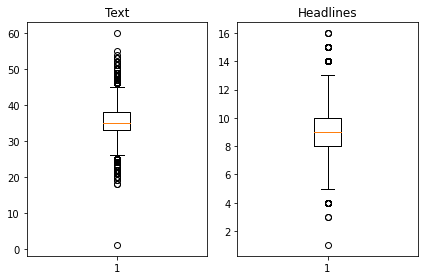

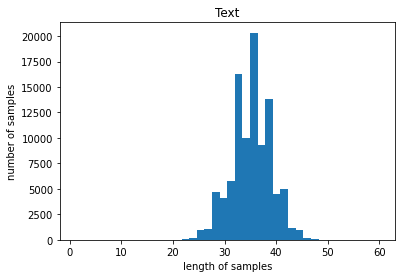

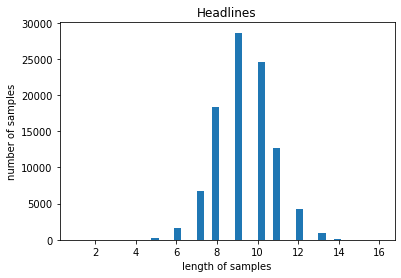

In [89]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']] # Text 데이터 행마다의 문장 길이를 리스트에 나열
headlines_len = [len(s.split()) for s in data['headlines']] # Headlines 데이터 행마다의 문장 길이를 리스트에 나열

print('텍스트의 최소 길이 : {}'.format(np.min(text_len))) # 가장 짧은 문장 길이
print('텍스트의 최대 길이 : {}'.format(np.max(text_len))) # 가장 긴 문장 길이
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len))) # Text 데이터 문장의 길이들의 평균
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의  최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의  평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40) # Text열의 문장 길이를 히스토그램으로 시각화, bins=40은 히스토그램 막대의 개수를 지정
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40) # Headlines열의 문장 길이를 히스토그램으로 시각화, bins=40은 히스토그램 막대의 개수를 지정
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

* Sample들의 길이가 정규분포의 형태를 띄고, 크게 벗어나는 값이 없어서 사용할 데이터의 길이를 제한하지 않고 그대로 사용한다.

#### 시작 토큰과 종료 토큰 추가하기

앞서 시작 토큰과 종료 토큰에 대해서 언급했던 것을 기억해보면, 디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈추는 것이었다.
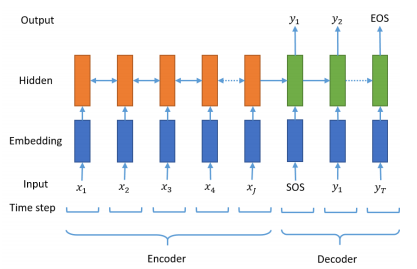
[시작 토큰 SOS와 종료 토큰 EOS는 각각 start of a sequence와 end of a sequence를 나타낸다]

seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있다. 이번 실습에서는 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가할 것이다. 

디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 이름을 정했다. 두 개의 문장 모두 Summary 열로부터 만들 것이다.

In [90]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


앞뒤로 토큰이 잘 붙은 것을 확인할 수 있다. 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장해 준다.

In [91]:
# Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [92]:
# 출력해서 형태 확인
print(encoder_input)
print('-'*90)
print(decoder_input)
print('-'*90)
print(decoder_target)

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak penn talks write script fil

In [93]:
# shape 확인
print(encoder_input.shape)
print(decoder_input.shape)
print(decoder_target.shape)

(98360,)
(98360,)
(98360,)


이제 훈련 데이터와 테스트 데이터를 분리할 것이다.

훈련 데이터와 테스트 데이터를 분리하는 방법은 분리 패키지를 사용하는 방법, 또는 직접 코딩을 통해서 분리하는 방법 등 여러 가지 방법이 있을 텐데 여기서는 직접 해보자. 우선, encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어주자.

In [94]:
indices = np.arange(encoder_input.shape[0]) # encoder_input 배열의 첫 번째 차원의 크기(데이터 샘플의 수), 0부터 encoder_input의 샘플의 수까지의 연속적인 정수 배열 생성
np.random.shuffle(indices) # indices 배열에 있는 값들을 무작위로 섞음, 이를 통해 데이터셋의 인덱스 순서를 랜점하게 조정
print(indices) 
print(len(indices))

[69594 42967 89682 ... 58654 59189 17766]
98360


In [95]:
# 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해, 잘 섞인 샘플을 만든다.
encoder_input = encoder_input[indices] # 섞인 인덱스의 순서대로 데이터가 재정렬
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리해 준다. 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의한다.

In [96]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19672


정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분한다. :표시의 위치에 주의해야 한다.

In [97]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


훈련 데이터와 테스트 데이터가 각각 78688개와 19672개로 잘 분리된 것을 볼 수 있다.

### 데이터 전처리하기 - 정수 인코딩

#### 단어 집합(vocabulary) 만들기 및 정수 인코딩
---
기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 한다. 이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요한다. 이 과정을 단어 집합(vocabulary) 을 만든다고 표현한다. 훈련 데이터에 대해서 단어 집합을 만들어보자. 

우선, 원문에 해당되는 encoder_input_train에 대해서 단어 집합을 만들자.

Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있다.

In [98]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [99]:
# 토큰화가 잘 되었는지 확인
list(src_tokenizer.word_index.items())[:10]

[('said', 1),
 ('india', 2),
 ('year', 3),
 ('added', 4),
 ('us', 5),
 ('also', 6),
 ('first', 7),
 ('government', 8),
 ('police', 9),
 ('people', 10)]

* 전체 중에 가장 앞쪽의 10개 정도만 출력해서 key, value 값을 확인 해 보면 정상적으로 입력 되어 있음을 알 수 있다.

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었다. 현재 생성된 단어 집합은 **src_tokenizer.word_index**에 저장되어 있다. 그런데 우리는 이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행하려고 한다.

등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해보자.

src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있다.

In [100]:
# 10개의 단어의 빈도수를 출력
list(src_tokenizer.word_counts.items())[:10]

[('samsung', 239),
 ('latest', 351),
 ('update', 169),
 ('virtual', 162),
 ('assistant', 299),
 ('bixby', 8),
 ('allows', 443),
 ('users', 2628),
 ('disable', 7),
 ('dedicated', 155)]

In [101]:
threshold = 7 # 여기에서 의미하는 희귀 단어들은 임계값인 7 미만인 단어들을 희귀 단어라고 지칭한다.
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69733
등장 빈도가 6번 이하인 희귀 단어의 수: 47534
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22199
단어 집합에서 희귀 단어의 비율: 68.16571780935855
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4926262274082833


* 단어 집합에서 희귀 단어의 비율이 70% 정도를 차지하는 반면, 전체 등장 빈도에서 희귀 단어 등장 빈도 비율은 3.5% 정도밖에 되지 않는다. 그렇게 때문에 제거하고, 단어집합의 크기를 대폭 줄이는 방향으로 진행하도록 한다.
* 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 한다. 위에서 이를 제외한 단어 집합의 크기를 22,000여 개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 22,000으로 제한해볼자. 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있다.

In [102]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 22,000으로 제한(해당 텍스트 데이터에서는 가장 빈도가 높은 22,000개의 고유한 단어만을 고려하여 토크나이징)
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


**texts_to_sequences()**는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행한다. 

현재 단어 집합의 크기를 22,000으로 제한했으니까 이제 22,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않는다.

In [103]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) # src_tokenizer 단어 집합에 기반하여 주어진 텍스트 데이터의 단어들을 모두 정수로 변환
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test) # src_tokenizer 단어 집합에 기반하여 주어진 텍스트 데이터의 단어들을 모두 정수로 변환

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[2141, 1506, 2888, 3009, 1745, 19430, 1196, 107, 20655, 3120, 19430, 3746, 2764, 2032, 1226, 2888, 3361, 1506, 1454, 19430, 19430, 137, 502, 19430, 137, 998, 3746, 15364, 100, 493, 7247, 239, 9833, 3746], [126, 31, 539, 680, 310, 2407, 393, 71, 176, 14, 1059, 539, 36, 943, 393, 338, 34, 9468, 16711, 11875, 250, 561, 3403, 5668, 14, 150, 6964, 135, 546, 14, 15365, 225, 394, 219, 1182, 3502], [1777, 192, 6312, 178, 430, 1490, 249, 959, 215, 6181, 178, 1358, 11570, 2541, 7248, 11570, 14291, 33, 18397, 33, 178, 437, 64, 12570, 178, 1029, 1, 12570, 2622, 1393, 2622, 616, 3248, 934, 14292]]


이제 더 이상 텍스트 데이터가 아니라 정수가 나오고 있다.

headlines 데이터에 대해서도 동일한 작업을 수행한다. 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산한다.

In [104]:
# 'Headlines' 에 대해 동일하게 처리
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [105]:
list(tar_tokenizer.word_index.items())[:10]

[('sostoken', 1),
 ('to', 2),
 ('in', 3),
 ('for', 4),
 ('of', 5),
 ('on', 6),
 ('india', 7),
 ('with', 8),
 ('not', 9),
 ('after', 10)]

In [106]:
# 10개 단어의 빈도수를 출력
list(tar_tokenizer.word_counts.items())[:10]

[('sostoken', 78688),
 ('samsung', 105),
 ('lets', 114),
 ('users', 561),
 ('disable', 3),
 ('dedicated', 9),
 ('bixby', 2),
 ('button', 25),
 ('priyanka', 410),
 ('chopra', 93)]

In [107]:
threshold = 7
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30074
등장 빈도가 6번 이하인 희귀 단어의 수: 20554
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9520
단어 집합에서 희귀 단어의 비율: 68.34474961760989
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.284188268791165


* text와 마찬가지로 headlines 데이터에 대해서도 단어의 집합을 9500으로 재조정한다.

In [108]:
tar_vocab = 9500
tar_tokenizer = Tokenizer(num_words=tar_vocab) # 단어 집합 크기를 9,500으로 제한
tar_tokenizer.fit_on_texts(decoder_input_train) # 입력된 데이터로부터 단어 집합 생성
tar_tokenizer.fit_on_texts(decoder_target_train) # 입력된 데이터로부터 단어 집합 생성

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1172, 1068, 152, 7701, 4018], [1, 227, 1312, 3, 187, 9, 195, 166, 4, 717, 35], [1, 2072, 6, 96, 38, 4400, 578, 2792, 315], [1, 780, 54, 6, 44, 1462, 572, 856, 1692, 3, 3103], [1, 227, 1227, 3596, 3, 70, 3322, 4, 404, 60]]
target
decoder  [[1172, 1068, 152, 7701, 4018, 2], [227, 1312, 3, 187, 9, 195, 166, 4, 717, 35, 2], [2072, 6, 96, 38, 4400, 578, 2792, 315, 2], [780, 54, 6, 44, 1462, 572, 856, 1692, 3, 3103, 2], [227, 1227, 3596, 3, 70, 3322, 4, 404, 60, 2]]


* 'input' 에는 1 이 처음에 들어가있고, 'target' 에는 2 가 끝에 들어가 있는 것을 볼 수 있다. 각각 sostoken, eostoken 을 뜻한다.

정상적으로 정수 인코딩 작업이 끝났다. 현재 decoder_input_train과 decoder_target_train에는 더 이상 숫자 9500이 넘는 숫자들은 존재하지 않는다. 그런데 다음 작업인 패딩 하기로 넘어가기 전에 한 가지 점검해야 할 것이 있다.

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있다. 이 현상은 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 4밖에 되지 않았던 요약문(Summary)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높다.

요약문에서 길이가 0이 된 샘플들의 인덱스를 받아와보겠다. 여기서 주의할 점은 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않는다. 그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나올 것이다. 길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있을 것이기 때문이다.

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장하겠다. 이 샘플들은 모두 삭제할 것이다.

In [109]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


### 패딩하기

텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야 해야 한다. 아까 정해두었던 최대 길이로 패딩 해 준다. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰준다.

In [110]:
text_max_len = 60
headlines_max_len = 16

In [112]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post') # text_max_len에 맞게 패딩하고, 짧은 데이터들은 시퀀스 뒷부분에 0을 추가하여 패딩
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post') # text_max_len에 맞게 패딩하고, 짧은 데이터들은 시퀀스 뒷부분에 0을 추가하여 패딩
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post') # summary_max_len에 맞게 패딩하고, 짧은 데이터들은 시퀀스 뒷부분에 0을 추가하여 패딩
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post') # summary_max_len에 맞게 패딩하고, 짧은 데이터들은 시퀀스 뒷부분에 0을 추가하여 패딩
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post') # summary_max_len에 맞게 패딩하고, 짧은 데이터들은 시퀀스 뒷부분에 0을 추가하여 패딩
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post') # summary_max_len에 맞게 패딩하고, 짧은 데이터들은 시퀀스 뒷부분에 0을 추가하여 패딩
print('=3')

=3


In [115]:
# 패딩 유무 확인
encoder_input_train

array([[2141, 1506, 2888, ...,    0,    0,    0],
       [ 126,   31,  539, ...,    0,    0,    0],
       [1777,  192, 6312, ...,    0,    0,    0],
       ...,
       [1025,  281, 1214, ...,    0,    0,    0],
       [ 296,  805, 1055, ...,    0,    0,    0],
       [ 244,   99, 3798, ...,    0,    0,    0]], dtype=int32)

학습에 필요한 전처리가 모두 끝났다.

### 모델 설계하기 (Encoder, Decoder 설계)
---
함수형 API를 이용해서 인코더를 설계해보자
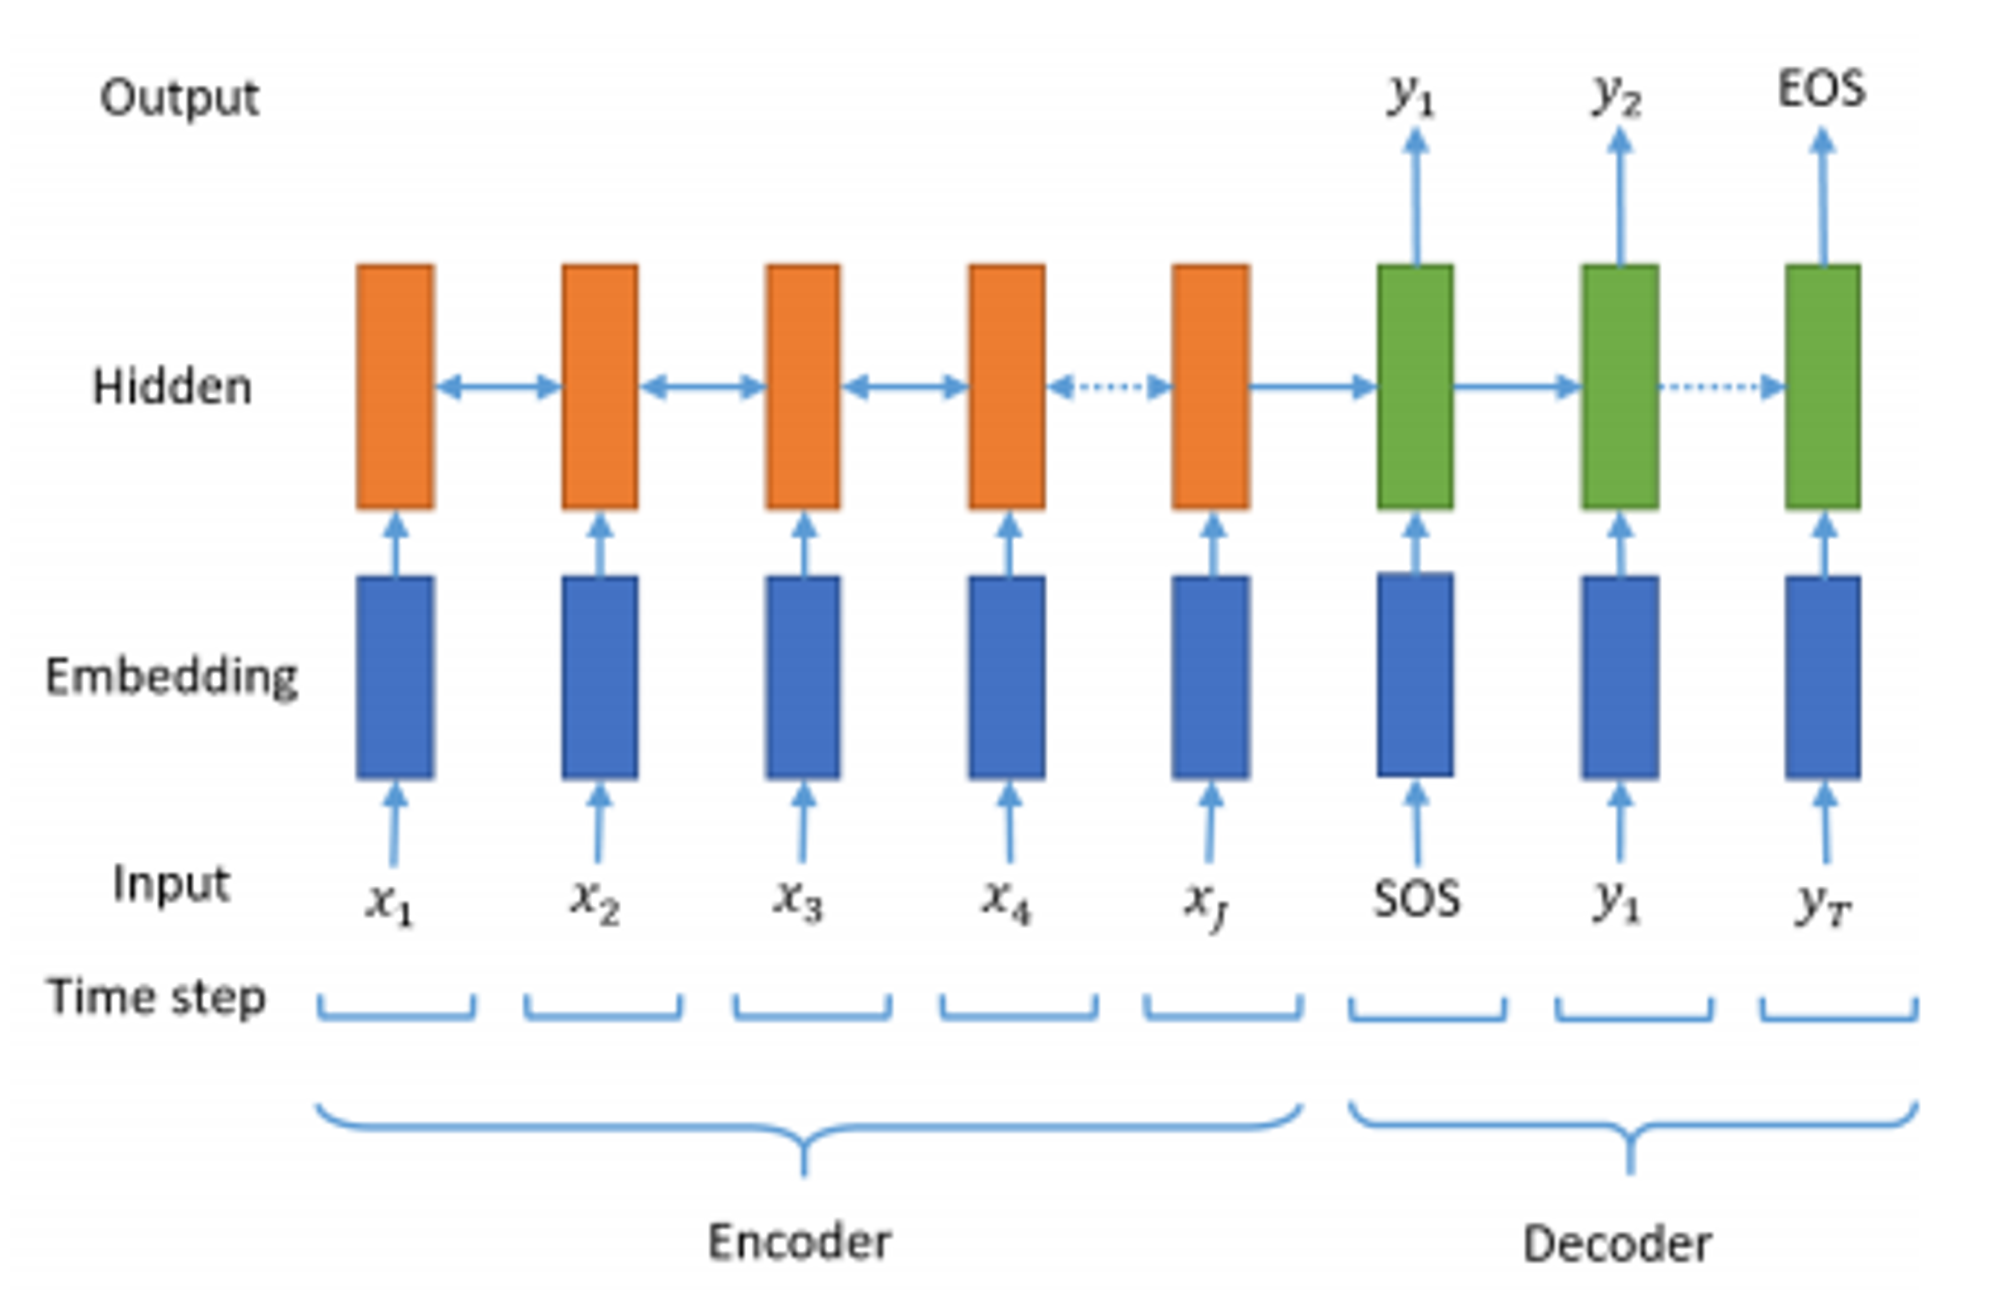
* LSTM (Long Short-Term Memory)의 hidden layer는 입력 데이터의 순서 정보와 그에 따른 의미를 유지하고 기억하는 레이어입니다. LSTM은 RNN (Recurrent Neural Network)의 한 종류로, 시퀀스 데이터에서 발생하는 장기 의존성 문제를 해결하기 위해 고안되었습니다. 이 hidden layer는 입력 데이터의 순서적인 특성을 고려하여 이전 시간 단계의 정보를 기억하고, 해당 정보를 다음 단계로 전달합니다. 이 과정을 통해 LSTM은 시퀀스 데이터의 패턴과 의미를 보다 잘 파악하고, 더 긴 기간 동안의 의존성을 학습할 수 있습니다. 이러한 능력으로 LSTM은 문장, 음성, 시계열 데이터 등과 같은 시퀀스 데이터를 처리하는 데 유용합니다.

* LSTM의 임베딩 레이어는 단어를 연속적인 공간에 매핑하는 역할을 합니다. 이는 단어를 밀집된 벡터로 변환하여 모델이 단어 간의 의미론적 관계를 이해하고, 이를 기반으로 입력 데이터를 처리할 수 있도록 돕습니다. 주로 텍스트 처리에서 사용되며, 텍스트를 숫자로 변환하는 기술인 워드 임베딩을 수행합니다. 단어들은 원-핫 인코딩 등의 희소한 형태에서 임베딩 레이어를 통해 밀집된 저차원 벡터로 표현됩니다. 이 벡터는 단어의 의미적 유사성을 캡처하여 모델이 단어의 상대적 의미를 학습할 수 있도록 돕습니다. 임베딩 레이어는 초기에 랜덤한 값을 갖지만, 모델 학습 과정에서 단어들 간의 관계와 의미를 파악하며 점차 업데이트되어 학습됩니다. 이러한 임베딩은 모델의 성능을 향상시키고 텍스트 데이터의 의미를 보다 효과적으로 이해할 수 있도록 도와줍니다.

**인코더 설계**
1. 임베딩 층 설정: 입력 시퀀스에 대한 임베딩을 수행합니다. Embedding 층은 입력 시퀀스의 각 단어를 임베딩 벡터로 변환합니다. src_vocab은 입력 데이터의 어휘 크기이며, embedding_dim은 임베딩 벡터의 차원을 나타냅니다.

2. 인코더 LSTM 레이어 구성: LSTM 셀을 이용하여 인코더를 구성합니다. 이 코드에서는 3개의 LSTM 레이어로 구성되어 있습니다. 각 레이어는 입력 시퀀스의 정보를 순차적으로 처리하고, return_sequences=True로 설정하여 모든 시간 단계에서 출력을 반환합니다. return_state=True로 설정하여 마지막 시간 단계의 은닉 상태와 셀 상태를 반환합니다. 또한, dropout 및 recurrent_dropout을 설정하여 과적합을 방지하기 위한 드롭아웃을 적용합니다.

3. 은닉 상태와 셀 상태 저장: 각 LSTM 레이어에서 얻은 마지막 시간 단계의 은닉 상태와 셀 상태를 각각 state_h1, state_c1, state_h2, state_c2, state_h3, state_c3에 저장합니다.

이렇게 구성된 인코더는 입력 시퀀스의 정보를 담은 상태 벡터와 셀 상태를 출력하며, 이러한 정보는 디코더로 전달되어 번역이나 요약 등의 작업을 수행하게 됩니다.

**hidden state와 cell state**

은닉 상태(hidden state)와 셀 상태(cell state)는 LSTM(Long Short-Term Memory) 레이어에서 사용되는 개념입니다.

* 은닉 상태 (Hidden State): LSTM의 각 시간 단계(time step)에서의 출력입니다. 현재 시간 단계의 입력과 이전 시간 단계의 은닉 상태를 기반으로 계산됩니다. 이는 현재까지의 입력 데이터를 통해 모델이 학습한 정보를 담고 있습니다.

* 셀 상태 (Cell State): LSTM이 정보를 기억하기 위해 사용하는 내부 메모리입니다. 각 시간 단계에서 셀 상태에는 입력 게이트, 삭제 게이트, 출력 게이트를 통해 정보가 얼마나 유지 또는 제거될지가 결정됩니다. 이러한 메커니즘을 통해 LSTM은 긴 시퀀스에서 중요한 정보를 유지하고 불필요한 정보를 잊어버립니다.

은닉 상태와 셀 상태는 LSTM이 시퀀스 데이터를 처리하고 이해하는 데 중요한 역할을 합니다. 각각 현재 시점의 출력과 내부적으로 기억하는 정보를 나타내며, 모델이 이를 통해 시퀀스의 패턴을 학습하고 예측하는 데 사용됩니다.

Hidden state의 크기를 늘리려면 hidden size를 늘리면 됩니다. Hidden size를 늘리면 모델이 각 시간 단계에서 더 많은 정보를 저장하고 더 복잡한 패턴을 학습할 수 있습니다. 하지만 더 큰 hidden size는 모델의 복잡성과 계산 비용을 늘리므로 적절한 크기를 선택하는 것이 중요합니다. 데이터의 복잡성과 모델의 용량 사이에 균형을 유지해야 합니다.

**Time step**

LSTM에서의 time step은 시퀀스 데이터를 구성하는 단계나 시간 단위를 나타냅니다. 시퀀스 데이터(예: 문장, 시계열 데이터)를 처리할 때, 각 단어나 각 시간 단계마다 LSTM에 데이터가 입력됩니다. 이때 입력되는 각 단계를 time step이라고 합니다. 예를 들어, 문장을 단어 단위로 처리할 경우 한 문장이 여러 time step으로 구성될 수 있습니다. 이러한 time step은 LSTM이 입력을 받고 출력을 생성하는 과정을 각각의 시간 단계로 처리하는데 사용됩니다.

In [116]:
# 함수형 API를 이용해서 인코더를 설계
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층 - 입력 시퀀스에 대한 임베딩을 수행한다.(Embedding 층은 입력 시퀀스의 각 단어를 임베딩 벡터로 변환 )
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs) # src_vocab은 입력 데이터의 어휘 크기, embedding_dim은 임베딩 벡터의 차원

# 각 LSTM 레이어는 입력 시퀀스의 정보를 순차적으로 처리한다.
# 인코더의 LSTM 1 - (return_sequences=True: 모든 시간 단계에서 출력을 반환, return_state=True: 마지막 시간 단계의 은닉 상태와 셀 상태를 반환
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4) # dropout 및 recurrent_dropout를 사용하여 과적합 방지
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout = 0.4, recurrent_dropout = 0.4 )
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout = 0.4, recurrent_dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

임베딩 벡터의 차원은 128로 정의하고, hidden state의 크기를 256으로 정의했다. hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터이다. 이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수라고 이해하면 된다. 다른 신경망과 마찬가지로, 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아니다.

인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였다. hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있다. 3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내줘야 한다.

또한 LSTM은 dropout 뿐 아니라 recurrent dropout까지 사용할 수 있다. 일반적인 dropout은 레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 해결해주는 방법이다.

반면 recurrent dropout은 dropout을 레이어가 아닌 time step마다 해주는 방식이다. 즉 time step의 입력을 랜덤으로 생략해 주는 것이다. recurrent dropout은 일반적인 dropout와 같이 regularization을 해주는 효과가 있고, 과적합을 방지할 수 있다고 한다.

아래 그림은 일반적인 dropout과, dropout과 recurrent dropout을 동시에 사용한 것을 시각적으로 표현한 것이다. 색이 있는 화살표는 dropout을 나타낸 것이다. (색이 다른 것은 다른 dropout mask를 사용했다는 표시인데, 지금은 그냥 넘어가도 된다.) 코드를 수정해서 LSTM에 dropout과 recurrent dropout을 모두 사용할 수 있다. 그렇게 되면 오른쪽 그림과 같은 형태가 된다. 참고로 dropout과 recurrent dropout을 모두 사용한 것을 Variational Dropout이라고도 한다.
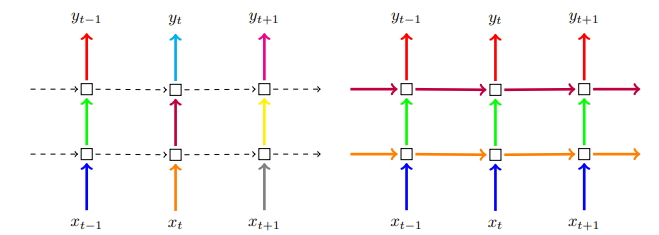
[dropout(왼쪽)과 dropout + recurrent dropout(오른쪽)]

참고로 recurrent dropout을 사용하면 아래와 같은 경고문이 뜬다.

WARNING:tensorflow:Layer lstm_15 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU

recurrent dropout을 사용할 시 cuDNN을 사용할 수 없어서 recurrent dropout을 사용하지 않을 때보다 학습 시간이 오래걸린다.

**이제 디코더를 설계해보자**

In [117]:
# 디코더 설계
decoder_inputs = Input(shape=(None,)) # 시퀀스 길이를 가변적으로 받을 수 있도록 None으로 설정

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일하다. 하지만 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 한다.

디코더의 출력층을 설계해보자.

In [118]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

디코더의 출력층에서는 Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 한다. 그렇기 때문에 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용하고 있다.

지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq이다. 그런데 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법이 있다. 바로 **어텐션 메커니즘**이다.

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
---
어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다는 뜻이다. 어텐션 함수를 설계해보는 것은 다음 기회로 미루기로 하고, 여기서는 TensorFlow에 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 배워보자. 참고로 여기서 사용하는 어텐션 함수는 Bahdanau 스타일의 어텐션이다. 이 어텐션에 대한 자세한 설명은 텐서플로우 홈페이지를 참고하자.

* https://www.tensorflow.org/api_docs/python/tf/keras/layers/AdditiveAttention

아래와 같이 어텐션 층을 만들고, 위에서 설계한 디코더의 출력층을 수정해 보자.

In [119]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있다.

### 모델 훈련하기

설계한 모델을 가지고 훈련을 진행해보자.

In [120]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1) # 조기 종료 설정
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 270s 848ms/step - loss: 4.2539 - val_loss: 3.8664
Epoch 2/50
308/308 [==============================] - 260s 844ms/step - loss: 3.7634 - val_loss: 3.6091
Epoch 3/50
308/308 [==============================] - 259s 840ms/step - loss: 3.5209 - val_loss: 3.4094
Epoch 4/50
308/308 [==============================] - 258s 837ms/step - loss: 3.3265 - val_loss: 3.2697
Epoch 5/50
308/308 [==============================] - 258s 836ms/step - loss: 3.1740 - val_loss: 3.1576
Epoch 6/50
308/308 [==============================] - 257s 836ms/step - loss: 3.0479 - val_loss: 3.0725
Epoch 7/50
308/308 [==============================] - 257s 834ms/step - loss: 2.9409 - val_loss: 3.0069
Epoch 8/50
308/308 [==============================] - 257s 835ms/step - loss: 2.8468 - val_loss: 2.9523
Epoch 9/50
308/308 [==============================] - 263s 854ms/step - loss: 2.7631 - val_loss: 2.9066
Epoch 10/50
308/308 [==============================] - 257s 835m

'조기 종료'를 뜻하는 EarlyStopping은 특정 조건이 충족되면 훈련을 멈추는 역할을 한다.

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
위 코드에서는 val_loss(검증 데이터의 손실)을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정돼 있다. EarlyStopping이 작동한다면 epochs가 아무리 크게 설정되어 있어도 모델 훈련을 최적점에서 멈출 수 있다.

EarlyStopping에 대한 자세한 내용은 아래 링크를 참고하자! 자주 쓰이는 도구이니 자세히 알아두면 매우 도움이 될 것이다.

* https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

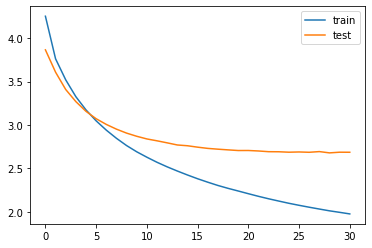

In [121]:
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현하기

테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해 둔다.

In [122]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다.

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했다.

그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 한다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계한다.

In [123]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


어텐션 메커니즘을 사용하는 출력층을 설계한다

In [124]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만든다.

In [128]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
---
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

###  모델 테스트하기

테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하다. 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어보자. 함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만들 것이다.

In [129]:
# seq2text 함수처럼 요약문의 정수 시퀀스를 텍스트로 변환하는 seq2summary 함수 코드를 작성
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교해보자.

In [130]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : boys trapped inside cave thailand sedated rescued pm chan said boys given minor calm nerves began dive boys trained breathe underwater oxygen tank diving experience 
실제 요약 : boys trapped in thailand cave were before rescue 
예측 요약 :  thai cave rescue kids trapped in cave for rescue kids


원문 : team india played four test matches stadium johannesburg winning one drawing three india test win stadium came sreesanth five wicket haul helped india dismiss south africa runs first innings india previous test johannesburg virat kohli slammed help india draw 
실제 요약 : india has never lost test match in 
예측 요약 :  india beat australia to win their th test series


원문 : blaming ball tampering scandal david warner wife candice said taken huge toll ex australian vice captain feel like fault killing added candice mocked drunken encounter rugby player warner also fought quinton de kock vile comments candice 
실제 요약 : feel like it all my fault warner wife on ball tampering 
예측 요약 :  david warner wife 

예측 요약 :  raina shares video of dhoni with his feet in his ipl


원문 : delhi department environment reportedly drawing standard operating procedure dispose road dust collected dozen mechanical sweepers order control air pollution level city additionally public works department floated tender procure six sweeping machines year 
실제 요약 : delhi government to fix rules for road dust 
예측 요약 :  delhi to get its own system to curb pollution


원문 : police monday said crpf jawan allegedly committed suicide shooting service rifle colleague poll bound chhattisgarh raipur belonging th battalion crpf jawan shot colleague ak rifle official said rushed nearby hospital declared dead arrival added 
실제 요약 : crpf jawan on poll duty shoots self in chhattisgarh raipur 
예측 요약 :  crpf jawan shoots himself in front of his rifle


원문 : led south sudan government slammed giving parliamentarians buy cars presidential spokesperson defended government move saying mps could expected use motorbikes south sudan facing e

예측 요약 :  who is the world cup trophy


원문 : actor starred austin powers movies mini harry potter movie died saturday aged family wrote instagram account depression suicide serious issues publicist said gone recent time however cause death announced 
실제 요약 : powers actor passes away aged 
예측 요약 :  assange killed suicide after accident


원문 : france midfielder paul pogba paid tribute late father holding fifa world cup trophy one hand shin pad picture father hand mom dad pogba wrote twitter winning tournament pogba also trophy celebrations 
실제 요약 : pogba holds wc trophy with pad as tribute to dad 
예측 요약 :  footballer pays tribute to wc after dad win


원문 : aam aadmi party contest seats upcoming assembly elections madhya pradesh give tickets new faces including ex army personnel engineers managers doctors young professionals said state convenor alok agarwal party chief ministerial candidate added people grown sick old faces parties 
실제 요약 : aap to contest from all seats in mp assembly elec

많은 결과가 출력이 되는데, 기존의 요약과는 다른 요약을 출력하면서도 원문의 내용을 담고 있는 의미 있는 요약들이 보인다. 심지어 일부 요약의 경우에는 원문에 없던 단어를 사용해서 요약을 하기도 하고 있다. 워드 임베딩과 RNN의 콜라보로 이뤄낸 신기한 성과이다.

물론 슬프게도 그다지 좋지 않은 요약의 예도 꽤나 보이기도 한다. 성능을 개선하기 위해서는 seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법도 있고, 빔 서치(beam search), 사전 훈련된 워드 임베딩(pre-trained word embedding), 또는 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)와 같은 여러 개선 방안들이 존재한다. 이런 방안들에 대해서도 향후 살펴보게 될 것이다.

## Step 5. Summa을 이용해서 추출적 요약해보기

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

---
앞서 seq2seq를 통해서 추상적 요약을 진행해봤다.. 그런데 텍스트 요약에는 추상적 요약 외에도 이미 본문에 존재하는 단어구, 문장을 뽑아서 요약으로 삼는 추출적 요약 방법도 있었다.

**추출적 요약 방법**: 추출적 요약은 원문에서 중요한 핵심 문장 또는 단어를 뽑아 구성된 요약문을 만드는 방식이다. 그래서 생성된 문장이나 단어는 원문에 포함되어 있기 때문에, 단점으로 언어 표현 능력이 제한되어 생성된 문장이 매끄럽지 않을 수 있다. 대표적인 알고리즘으로는 TextRank가 있다.

패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공하고 있어 아주 간단하게 실습을 해볼 수 있다. 영화 매트릭스 시놉시스를 요약해보면서 summarize 사용법을 익혀보자.


### 패키지 설치
---
클라우드의 경우 이미 summa 가 설치돼 있다. 확인해보고 싶으시면 아래 명령어를 Cloud Shell에서 실행해보자.
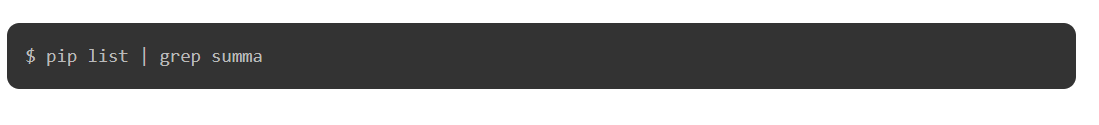

### 데이터 다운로드하기

In [131]:
import requests
from summa.summarizer import summarize

In [132]:
data2 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [133]:
for idx, text in enumerate(data2['text'][:10]):
    print(f'<Original_{idx+1}:> \n{text}')
    print(f'[Summary:] \n{summarize(text, words=20)}\n')

<Original_1:> 
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
[Summary:] 
The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.

<Original_2:> 
Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
[Summary:] 
Users get one CRED coin per r

### 평가: 추상적 요약(1) vs 추출적 요약(2)

(1) 추상적 요약
원문 : boys trapped inside cave thailand sedated rescued pm chan said boys given minor calm nerves began dive boys trained breathe underwater oxygen tank diving experience 
실제 요약 : boys trapped in thailand cave were before rescue 
예측 요약 :  thai cave rescue kids trapped in cave for rescue kids

-> 실제 요약은 원문의 'boys trapped inside cave thailand'의 핵심 내용을 'boys trapped in thailand cave'로 잘 반영해서 요약을 한 것을 볼 수 있다. 하지만 예측 요약은 'trapped in cave'을 통해 원문의 내용을 어느 정도 보여주고는 있으나, 핵심적인 정보 전달이 부족하다.

(2) 추출적 요약
원문: New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.
요약: The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.

-> 원문의 마지막 문장 중 'The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket histor' 부분을 요약해준 것을 볼 수 있다. 원문의 문자에서도 핵심 내용이기 때문에 요약을 잘 추출한 것을 볼 수 있다. 하지만 추상적 요약에 비하면, 원문의 부분적인 부분만 전달을 하고 있기 때문에 원문 전체의 내용의 정보를 전달하는 데 있어서는 부족한 부분이 있다.

결론:

결론적으로 원문의 전체적인 내용의 요약 추출해야 할 땐, 추상적 요약이 도움이 될 것 같고, 원문에서도 핵심적인 요약을 추출해야 한다면 추출적 요약이 도움이 될 것 같다.

### 회고문

RNN과 NLP를 너무 안 해봐서 그런지, 내용들이 생소했고, 이 생소한 내용들이 심지어 이해하기도 어려웠다 ㅠㅠ.. 전처리도 어려운데, 모델의 구조도 이해가 되지 않았다. 아무래도 RNN의 내용도 생각이 잘 나지 않기 때문에 복습을 해야 할 것 같다는 생각이 들었고, LSTM과 어텐션도 따로 공부를 하지 않으면 이 구조를 절대 이해하지 못 할 것 같다 ㅠㅠ 그리고 평가를 어떻게 진행해야 할지도 감이 전혀 오지 않았다.. 그것도 공부해야 할 것 같다..

**KEEP:** 프로젝트를 진행하면서 전처리 과정을 다시 복습하면서 이해하려고 했다. 최대한 이해되지 않은 부분은 구글링하고 GPT를 이용해서 이해하려고 했다.

**Problem:** 전처리는 어느 정도 이해를 했는데, 모델 구조를 이해하지 못 했다.. 또 평가 지표에 대한 것도 아직 명확해진 게 없다.

**Try:** 주말에 RNN에 대해서 복습하고 추가적인 공부를 진행하고, LSTM과 Attention에 대해서도 공부를 진행해야 할 것 같다. 데이터 전처리 부분도 복습을 하면 좀 더 명확해질 것 같기 때문에 복습을 진행한다. 평가를 하는 부분도 좀 더 구글링해봐야 할 것 같다.